In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop
import datetime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d, CubicSpline

# 0. Methods

In [60]:
# u_ss, v_ss, A, phi are all vectors in z
def inertial_oscillation(u_ss, v_ss, A, phi, f, t):
    u = u_ss + A * np.sin(f*t + phi)
    v = v_ss + A * np.cos(f*t + phi)
    return (u, v)

# computed for a single altitude z, with constants that do not vary with z
def ekman_taylor(Ug0, Ugz, z, H, A):
    [ug, vg] = Ug0 + Ugz * z
    [ugz, vgz] = Ugz
    [ug0, vg0] = Ug0
    u0 = ((2+A)*ug0 + (1+A)*H*ugz - (A*vg0 - H*vgz)) / (1 + (1+A)**2)
    v0 = ((2+A)*vg0 + (1+A)*H*vgz + (A*ug0 - H*ugz)) / (1 + (1+A)**2)
    eta = z / H
    u = ug + np.exp(-eta)*((u0 - ug0)*np.cos(eta) + (v0 - vg0)*np.sin(eta))
    v = vg + np.exp(-eta)*((v0 - vg0)*np.cos(eta) - (u0 - ug0)*np.sin(eta))
    return [u, v]

# computed for a time series ts
def coupled_IO_EkT(z, ts, Ug0, Ugz, H, A, f, A_io, phi):
    u_ss = np.zeros_like(z)
    v_ss = np.zeros_like(z)
    for (i, z) in enumerate(z):
        (u, v) = ekman_taylor(Ug0, Ugz, z, H, A)
        u_ss[i] = u
        v_ss[i] = v
    
    u_model = np.zeros((len(u_ss), len(ts)))
    v_model = np.zeros((len(v_ss), len(ts)))

    for (j, t) in enumerate(ts):
        (u, v) = inertial_oscillation(u_ss, v_ss, A_io, phi, f, t)
        u_model[:, j] = u[:]
        v_model[:, j] = v[:]

    return (u_model, v_model)

In [61]:
def extrapolate_A_in_z(A_like, z_meas, z_full):
    spline = CubicSpline(z_meas, A_like, bc_type='not-a-knot')
    A_full = spline(z_full)
    return A_full

def extrapolate_phi_in_z(phi_like, z_meas, z_full):
    func = interp1d(z_meas, phi_like, bounds_error=False, fill_value=(phi_like[0], phi_like[-1]))
    phi_full = func(z_full)
    return phi_full

In [62]:
def rews(ws, z_full, z_hub=150.0, d_rotor=240.0):
    rews = 0.0
    A_sum = 0.0
    dz = z_full[1] - z_full[0]
    for (i, z) in enumerate(z_full):
        if z <= z_hub + d_rotor/2 and z >= z_hub - d_rotor/2:
            dA = 2 * np.sqrt((d_rotor/2)**2 - (z - z_hub)**2) * dz
            A_sum += dA
            rews += ws[i]**3 * dA
    rews = (rews / A_sum)**(1/3)
    return rews

In [63]:
def monotonic_similar_profile(u_llj, v_llj, ts, z_full):
    ws_llj = np.sqrt(u_llj**2 + v_llj**2)
    ws_mon = np.zeros_like(ws_llj)
    for (j, t) in enumerate(ts):
        (V_hub, z_hub, alpha) = fit_normal_wind_profile(ws_llj[:,j], z_full)
        ws_mon[:,j] = normal_wind_profile(z_full, V_hub)
    return ws_mon

def normal_wind_profile(z_full, V_hub, alpha=0.2, z_hub = 150.0):
    V_nwp = V_hub * (z_full / z_hub)**alpha
    return V_nwp

def fit_normal_wind_profile(ws_llj, z_full, z_hub = 150.0, d_rotor = 240.0, alpha=0.2):
    REWS = rews(ws_llj, z_full)
    ws_vhub1 = normal_wind_profile(z_full, 1.0)
    REWS_Vhub1 = rews(ws_vhub1, z_full)
    V_hub = (REWS**3 / REWS_Vhub1) ** (1/3)
    return (V_hub, z_hub, alpha)

In [64]:
def find_veer_wd(u_llj, v_llj, z_full, ts, z_hub = 150.0, d_rotor = 240.0):
    wd_llj = 270 - np.arctan(v_llj/u_llj)/np.pi*180
    wd_mon = np.zeros_like(wd_llj)

    dz = z_full[1] - z_full[0]
    iz_lower = np.int8((z_hub - d_rotor/2) / dz)
    iz_upper = np.int8((z_hub + d_rotor/2) / dz)
    for (j, t) in enumerate(ts):
        rotor_mean_wd = np.mean(wd_llj[iz_lower:iz_upper+1,j])
        rotor_veer = (wd_llj[iz_upper+1,j] - wd_llj[iz_lower,j]) / d_rotor
        wd_mon[:,j] = rotor_mean_wd + (z_full - z_hub)*rotor_veer

    return wd_mon

## Global parameters

In [65]:
lat = 39.68 # E06 NYSERDA
f = 2*7.2921e-5 * np.sin(lat/180 * np.pi) # coriolis term
ts = np.linspace(0.0, 64200.0, 108, endpoint=True)
z_meas = np.linspace(20.0, 200.0, 10, endpoint=True)
z_max = 300.0
z_full = np.linspace(0.0, z_max, 31, endpoint=True)

# 1. April 5, 2020

In [66]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.00798544, 2.22849615, 2.37999955, 2.52865217, 2.87319412,
       3.3479224 , 3.66881104, 3.80117867, 3.8632125 , 3.92861221]
phi_sol = [-2.4221749 , -2.42339026, -2.44738343, -2.4481413 , -2.44002436,
       -2.42369966, -2.43545793, -2.44755539, -2.46596697, -2.47679609]
[ug0, vg0, ugz, vgz, H, A] = [13.644925689368524,
                            -1.2756346980178186,
                            -0.021819100072149343,
                            0.01166601584774272,
                            97.95759207844081,
                            3.121164479776965]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)

# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)

# No veer
u_mon_nv = ws_mon
v_mon_nv = np.zeros_like(u_mon)

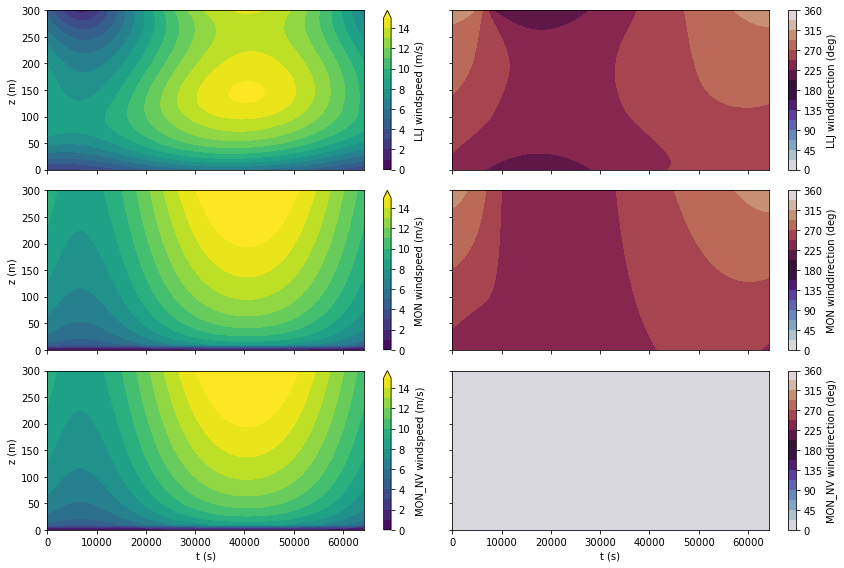

In [67]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 8))
clevels = np.linspace(0.0, 15.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')
ax[0][0].set_ylabel('z (m)')
ax[1][0].set_ylabel('z (m)')
ax[2][0].set_ylabel('z (m)')
ax[2][0].set_xlabel('t (s)')
ax[2][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')

plt.tight_layout()
#lt.savefig('figures/April5.pdf')

In [68]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full)
    )
)
profiles_xr = profiles_xr.assign_coords(case="April 5")
profiles_xr.to_netcdf("data/April5.nc")

PermissionError: [Errno 13] Permission denied: b'/Users/emilydejong/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/2023NREL/postprocessing-selected/data/April5.nc'

# 2. May 15, 2020

In [ ]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.0291243 , 2.17961936, 2.40684779, 2.53439411, 2.8572963 ,
       3.2945338 , 3.95209183, 4.46597354, 4.85347256, 5.14624811]
phi_sol = [-3.1110805 , -3.07069772, -3.14059265, -3.14059265, -3.11525664,
       -3.13661336, -3.14059265, -3.14059265, -3.14059265, -3.14059265]
[ug0, vg0, ugz, vgz, H, A] = [23.50242784844371,
                            3.1076113794128686,
                            -0.0349085023379044,
                            0.016379922268969924,
                            149.754138797046,
                            2.3878984756540467]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)

# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)

# No veer
u_mon = ws_mon
v_mon = np.zeros_like(u_mon)


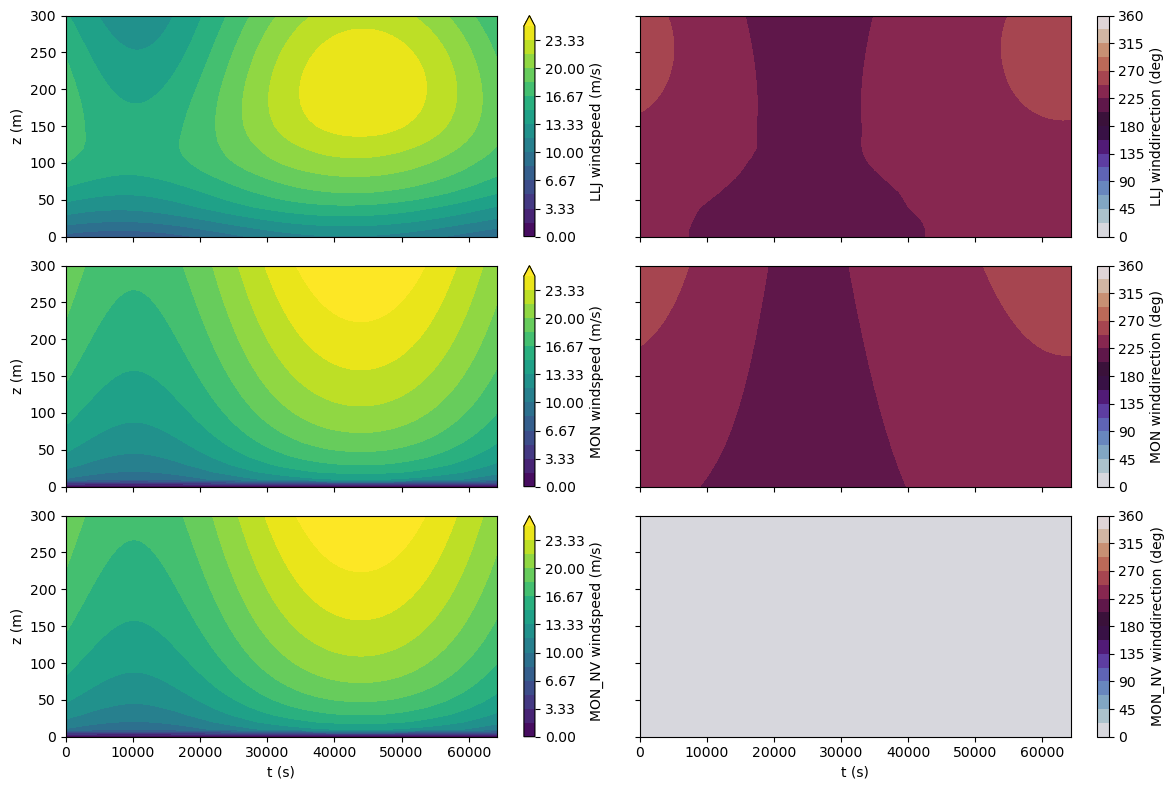

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 8))
clevels = np.linspace(0.0, 25.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')
ax[0][0].set_ylabel('z (m)')
ax[1][0].set_ylabel('z (m)')
ax[2][0].set_ylabel('z (m)')
ax[2][0].set_xlabel('t (s)')
ax[2][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')

plt.tight_layout()


In [ ]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full)
    )
)
profiles_xr = profiles_xr.assign_coords(case="May 15")
profiles_xr.to_netcdf("data/May15.nc")

# 3. June 3, 2020

In [ ]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.26114967, 3.68770764, 4.29829284, 4.50066681, 4.6494946 ,
       4.71730911, 4.79646542, 4.88814777, 4.94984601, 4.89826885]
phi_sol = [-1.31559234, -1.3375867 , -1.26318318, -1.22029833, -1.17609762,
       -1.13138398, -1.09483457, -1.07141242, -1.05016715, -1.02889363]
[ug0, vg0, ugz, vgz, H, A] = [4.89093328604861,
                            2.8165603758773927,
                            0.0021480563543068328,
                            -0.010520234577744508,
                            40.001485083825415,
                            0.425005147884652]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)
# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)
# No veer
u_mon = ws_mon
v_mon = np.zeros_like(u_mon)


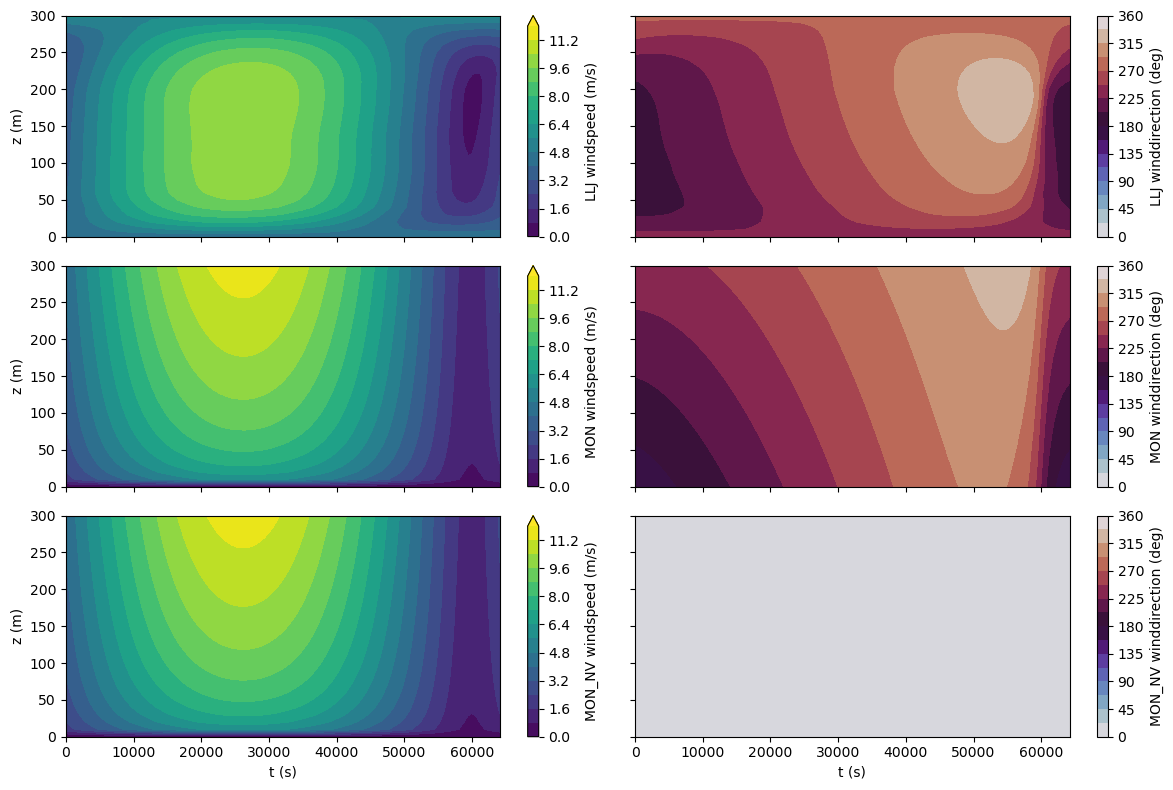

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 8))
clevels = np.linspace(0.0, 12.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')
ax[0][0].set_ylabel('z (m)')
ax[1][0].set_ylabel('z (m)')
ax[2][0].set_ylabel('z (m)')
ax[2][0].set_xlabel('t (s)')
ax[2][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')

plt.tight_layout()
#lt.savefig('figures/April5.pdf')

In [ ]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full)
    )
)
profiles_xr = profiles_xr.assign_coords(case="June 3")
profiles_xr.to_netcdf("data/June3.nc")

# 4. Plotting

In [ ]:
ds0 = xr.open_dataset('data/April5.nc')
ds1 = xr.open_dataset('data/May15.nc')
ds2 = xr.open_dataset('data/June3.nc')

ds = xr.concat([ds0, ds1, ds2], dim='case')

ds.to_netcdf('data/all_inflows.nc')

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (case: 3, z: 31, t: 108)
Coordinates:
    t_sec    (t) float64 0.0 600.0 1.2e+03 1.8e+03 ... 6.3e+04 6.36e+04 6.42e+04
  * z        (z) float64 0.0 10.0 20.0 30.0 40.0 ... 270.0 280.0 290.0 300.0
  * case     (case) <U7 'April 5' 'May 15' 'June 3'
Dimensions without coordinates: t
Data variables:
    u_llj    (case, z, t) float64 2.559 2.49 2.424 2.362 ... 5.88 5.877 5.873
    v_llj    (case, z, t) float64 1.106 1.17 1.239 ... -0.3822 -0.4013 -0.4203
    u_mon    (case, z, t) float64 0.0 0.0 0.0 -0.0 ... 1.773 2.015 2.276 2.55
    v_mon    (case, z, t) float64 -0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ws_llj   (case, z, t) float64 2.788 2.751 2.722 2.701 ... 5.892 5.89 5.888
    wd_llj   (case, z, t) float64 246.6 244.8 242.9 241.0 ... 273.7 273.9 274.1
    ws_mon   (case, z, t) float64 0.0 0.0 0.0 0.0 0.0 ... 1.773 2.015 2.276 2.55
    wd_mon   (case, z, t) float64 239.5 238.5 237.5 236.7 ... 246.2 244.1 242.6

In [ ]:
def plot_wd_ws_snapshots(ax, case, timestamps):
    data = ds.sel(case=case)
    for (i, timestamp) in enumerate(timestamps):
        it = int(timestamp * 3600.0 / 600.0)
        # windspeed
        line = ax[0].plot(data['ws_llj'].isel(t = it), data['z'], '-', label=str(timestamp)+'hr',color=plt.cm.copper(timestamp/18))
        color = line[-1].get_color()
        ax[0].plot(data['ws_mon'].isel(t = it), data['z'], '--', color=color)

        # winddirection
        if i == 0:
            lbl = ''
        else:
            lbl = '_'
        ax[1].plot(data['wd_llj'].isel(t = it), data['z'], '-', color=color, label=lbl+'LLJ')
        ax[1].plot(data['wd_mon'].isel(t = it), data['z'], '--', color=color, label=lbl+'MS')
        
        # turbine reference points
        ax[0].axhline(150.0, 0, 1, ls=':',color='k')
        ax[0].axhspan(30.0, 270.0, 0, 1, alpha=0.05, color='k')
        ax[1].axhline(150.0, 0, 1, ls=':',color='k')
        ax[1].axhspan(30.0, 270.0, 0, 1, alpha=0.05, color='k')
        
    ax[0].set_ylabel('altitude (m)')
    ax[0].set_xlabel('windspeed (m/s)')
    ax[0].set_xlim([0.0, 28.0])
    ax[1].set_xlim([200.0, 310.0])
    ax[1].set_xlabel('direction (deg)')

    ax[0].text(-5.0, 120.0, case, rotation=90,fontsize=14)

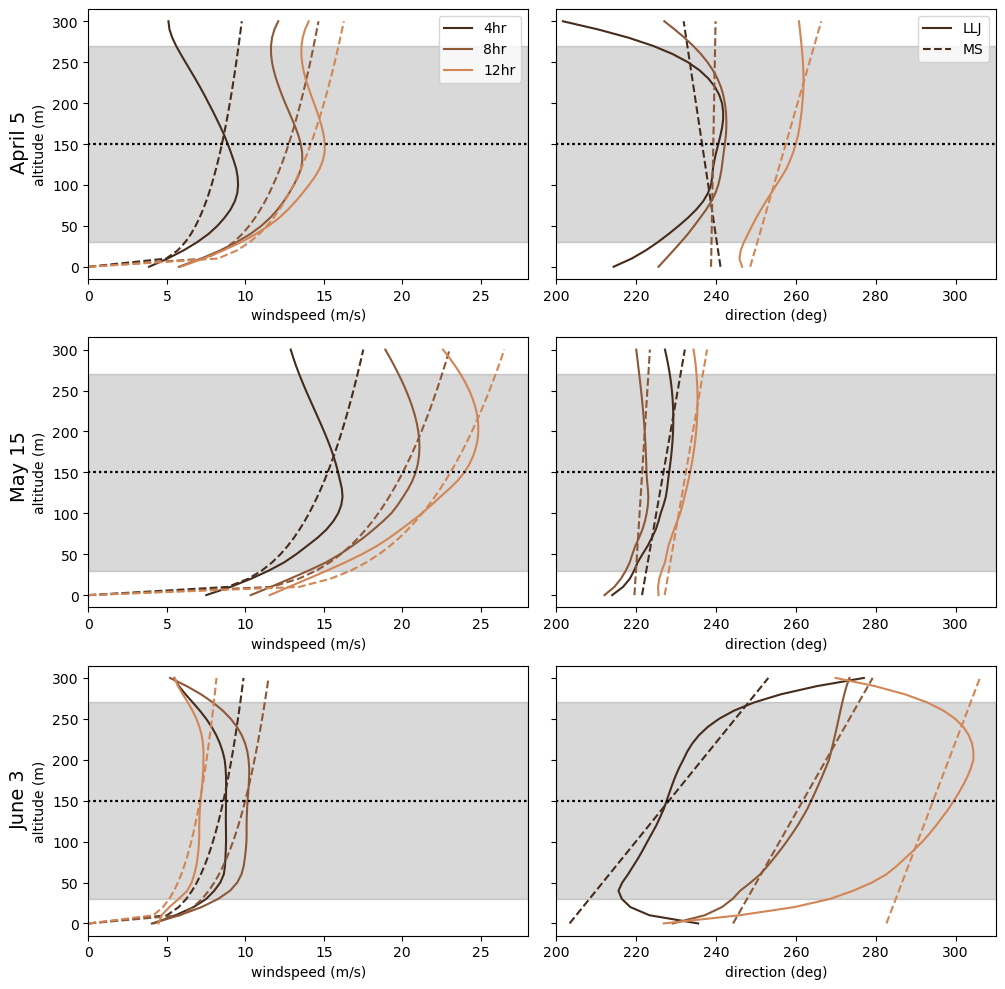

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10, 10), sharey=True)
timestamps = [4, 8, 12]
for (j, case) in enumerate(['April 5', 'May 15', 'June 3']):
    plot_wd_ws_snapshots(ax[j], case, timestamps)

ax[0][0].legend()
ax[0][1].legend()
plt.tight_layout()

plt.savefig('figures/fig1_windsetups.pdf', bbox_inches='tight')

In [ ]:
ds['HH_WS_LLJ'] = ds['ws_llj'].sel(z=150)
ds['HH_WS_MON'] = ds['ws_mon'].sel(z=150)
ds['mean_veer_LLJ'] = ds['wd_llj'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_veer_MON'] = ds['wd_mon'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_shear_LLJ'] = ds['ws_llj'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_shear_MON'] = ds['ws_mon'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['max_ws_LLJ'] = ds['ws_llj'].sel(z=slice(30, 240)).max('z')
ds['max_ws_MON'] = ds['ws_mon'].sel(z=slice(30, 240)).max('z')

tmp = ds['ws_llj'].differentiate('z').sel(z=slice(30, 240))
ds['neg_shear_LLJ'] = tmp.where(tmp < 0.0).mean('z')/10.0

In [ ]:
iz_max = ds['ws_llj'].sel(z=slice(30, 240)).argmax('z')
tmp = np.zeros_like(ds['max_ws_LLJ'])
for (t, tsec) in enumerate(ds['t_sec']):
    for (c, case) in enumerate(ds['case']):
        tmp[c, t] = ds['z'].isel(z = iz_max.values[c,t])

ds['z_max_LLJ'] = ('case','t'), tmp
ds['z_max_MON'] = ('case', 't'), np.zeros_like(tmp)*0.0+240.0

In [ ]:
ds

<xarray.Dataset>
Dimensions:         (case: 3, z: 31, t: 108)
Coordinates:
    t_sec           (t) float64 0.0 600.0 1.2e+03 ... 6.3e+04 6.36e+04 6.42e+04
  * z               (z) float64 0.0 10.0 20.0 30.0 ... 270.0 280.0 290.0 300.0
  * case            (case) <U7 'April 5' 'May 15' 'June 3'
Dimensions without coordinates: t
Data variables: (12/19)
    u_llj           (case, z, t) float64 2.559 2.49 2.424 ... 5.88 5.877 5.873
    v_llj           (case, z, t) float64 1.106 1.17 1.239 ... -0.4013 -0.4203
    u_mon           (case, z, t) float64 0.0 0.0 0.0 -0.0 ... 2.015 2.276 2.55
    v_mon           (case, z, t) float64 -0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws_llj          (case, z, t) float64 2.788 2.751 2.722 ... 5.892 5.89 5.888
    wd_llj          (case, z, t) float64 246.6 244.8 242.9 ... 273.7 273.9 274.1
    ...              ...
    mean_shear_MON  (case, t) float64 0.001525 0.001499 ... 0.0003662 0.0004102
    max_ws_LLJ      (case, t) float64 8.974 8.874 8.783 ... 2.764 2.903 3.051
    max_ws_MON      (case, t) float64 9.065 8.909 8.765 ... 1.927 2.177 2.439
    neg_shear_LLJ   (case, t) float64 -0.001667 -0.001748 ... -0.0007164
    z_max_LLJ       (case, t) float64 70.0 70.0 70.0 70.0 ... 0.0 0.0 0.0 0.0
    z_max_MON       (case, t) float64 240.0 240.0 240.0 ... 240.0 240.0 240.0

In [ ]:
def plot_scatter(ax, property1, property2, property1_label, property2_label, both='True'):
    for case in ds['case']:
        if both:
            for type in ['LLJ','MON']:
                data1 = ds[property1+'_'+type].rolling(t=6).mean().isel(t=slice(5,None,6))
                data2 = ds[property2+'_'+type].rolling(t=6).mean().isel(t=slice(5,None,6))
                if type=='LLJ':
                    line = ax.plot(data1.sel(case=case), data2.sel(case=case), label=str(case.values)+' LLJ', marker='^', fillstyle='none', linestyle='none', ms=8)
                else:
                    color = line[-1].get_color()
                    ax.plot(data1.sel(case=case), data2.sel(case=case), label=str(case.values)+' MS', marker='.', fillstyle='full', linestyle='none', ms=10, color=color)
        else:
            data1 = ds[property1].isel(t=slice(0, -1, 6))
            data2 = ds[property2].isel(t=slice(0, -1, 6))
            ax.plot(data1.sel(case=case), data2.sel(case=case.values), label=case, marker='^', fillstyle='none', linestyle='none', ms=8)
    
    ax.set_xlabel(property1_label)
    ax.set_ylabel(property2_label)

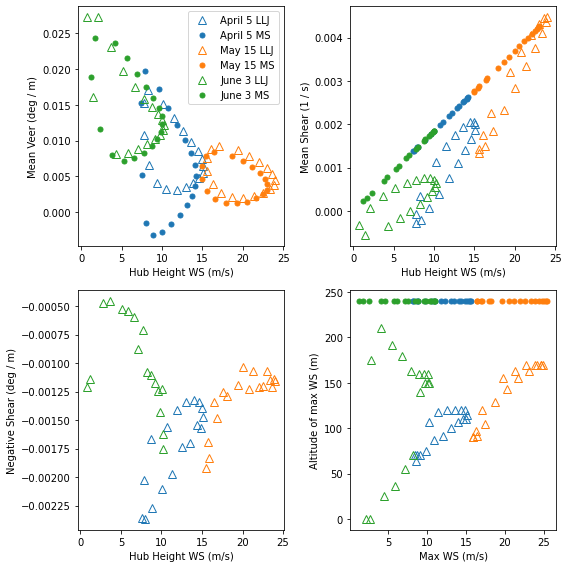

In [ ]:
(fig, ax) = plt.subplots(2, 2, figsize=(8,8))
plot_scatter(ax[0][0], 'HH_WS', 'mean_veer', 'Hub Height WS (m/s)', 'Mean Veer (deg / m)', both=True)
ax[0][0].legend()
plot_scatter(ax[0][1], 'HH_WS', 'mean_shear', 'Hub Height WS (m/s)', 'Mean Shear (1 / s)', both=True)
plot_scatter(ax[1][0], 'HH_WS_LLJ', 'neg_shear_LLJ', 'Hub Height WS (m/s)', 'Negative Shear (deg / m)', both=False)
plot_scatter(ax[1][1], 'max_ws', 'z_max', 'Max WS (m/s)', 'Altitude of max WS (m)', both=True)

plt.tight_layout()
plt.savefig('figures/fig2_setup_stats.pdf')

In [ ]:
ds.to_netcdf('data/processed_inflows.nc')